## Download and importing of libraries

In [2]:
%%capture
!pip install --upgrade tensorflow==2.15.0 keras==2.15.0 roboflow
!pip install --upgrade tensorflow-probability==0.23.0
!pip install -U git+https://github.com/aguirrejuan/ConvRFF.git

In [3]:
# General Libraries
import os
import re
import glob
import time
import shutil
import random
import warnings
import pandas as pd
import seaborn as sns
from enum import auto, Enum
from functools import partial
from datetime import datetime

# Image Processing Libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from keras_tuner import Objective
from keras_tuner import HyperModel
import tensorflow.keras.backend as K
from keras.layers import Layer, Activation
from keras_tuner import BayesianOptimization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import get_custom_objects
from keras_tuner.engine.hyperparameters import HyperParameters
from keras_tuner import BayesianOptimization as OriginalBayesianOptimization
from keras_tuner.oracles import BayesianOptimizationOracle as OriginalBayesianOptimizationOracle

# Machine Learning Libraries - Sklearn
import sklearn

# Deep Learning Libraries - TensorFlow specific
from tensorflow.keras.losses import Loss
from tensorflow.keras.metrics import Metric
from tensorflow.keras import Model, layers, regularizers
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.models import load_model
import tensorflow_probability as tfp

from roboflow import Roboflow

# Other Libraries
import gc
import json
import itertools
from PIL import ImageFont, Image
from dataclasses import dataclass
from matplotlib.style import available
from tensorflow.python.framework.ops import EagerTensor
from scipy.stats import ttest_ind


from IPython.display import FileLink

warnings.filterwarnings("ignore") # Disable warnings

2025-03-04 04:14:57.208374: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-04 04:14:57.208494: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-04 04:14:57.524406: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Load the Segmentation Model, model-best.h5

In [7]:
!cp -r /kaggle/input/model-segmentation/model-best.h5 /kaggle/working/

## Download the feet-mamitas Data Base

In [8]:
rf = Roboflow(api_key="9smAmQgaD8pNOTsDMYKR")
project = rf.workspace("mamitas").project("feet-mamitas")
version = project.version(1)
dataset = version.download("png-mask-semantic")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Feet-Mamitas-1 in png-mask-semantic:: 100%|██████████| 716/716 [00:00<00:00, 10790.37it/s]


In [9]:
# Setting the numpy seed
np.random.seed(42)

# Setting the tensorflow seed
tf.random.set_seed(42)

## Loading the batches

In [10]:
class CustomDataLoaderV2:
    """
    Custom DataLoader for loading and processing image patches and masks from a specified directory.

    Args:
        data_dir (str): Directory containing dataset images and masks.
        batch_size (int): Batch size for the dataset.
        image_size (tuple): Desired size of images (height, width).
        num_classes (int): Number of segmentation classes.
        num_annotators (int): Number of annotators per sample.

    Methods:
        load_patch_images: Loads and processes patch images from the specified directory.
        load_masks: Loads and processes mask images.
        get_dataset: Combines patches and masks into a batched and prefetched dataset.
    """
    
    def __init__(self, data_dir, batch_size, image_size, partition):
        """
        Initializes the CustomDataLoader with the specified parameters.

        Args:
            data_dir (str): Base directory of the dataset.
            batch_size (int): Number of samples per batch.
            image_size (tuple): Target size of images (height, width).
            num_classes (int): Total number of classes.
            num_annotators (int): Number of annotators providing masks.
            partition (str): Subdirectory to use (e.g., 'Train', 'Validation').
        """
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.partition = partition

    def load_patch_images(self):
        """
        Loads the patch images from the specified directory.

        Returns:
            tf.data.Dataset: A dataset of processed image tensors.
        """
        # Create the path for patch images
        patch_path_pattern = os.path.join(self.data_dir, self.partition, '*.jpg')
        patch_files = glob.glob(patch_path_pattern)
        
        # Key function to convert numbers in strings to integers for sorting
        def alphanumeric_key(s):
            # Split the string into parts (numbers and text)
            parts = re.split(r'(\d+)', s)
            # Convert numeric parts to integers, leaving non-numeric parts unchanged
            return [int(part) if part.isdigit() else part for part in parts]
        
        patch_files = sorted(patch_files, key=alphanumeric_key)

        # Print the complete path and the number of found patch images
        print(f"Complete path for patches: {patch_path_pattern}")
        print(f"Number of patch files found: {len(patch_files)}")

        # Create a TensorFlow dataset from the patch file paths
        patch_ds = tf.data.Dataset.from_tensor_slices(patch_files)

        # Map each file path to a processed image
        patch_ds = patch_ds.map(self.process_patch, num_parallel_calls=tf.data.AUTOTUNE)

        return patch_ds

    def load_masks(self):
        """
        Loads and processes masks from the specified directory.

        Returns:
            tf.data.Dataset: A dataset of processed mask tensors.
        """
        # Create the path for masks images
        mask_path_pattern = os.path.join(self.data_dir, self.partition,'*.png')
        mask_files = glob.glob(mask_path_pattern)
        
        # Key function to convert numbers in strings to integers for sorting
        def alphanumeric_key(s):
            # Split the string into parts (numbers and text)
            parts = re.split(r'(\d+)', s)
            # Convert numeric parts to integers, leaving non-numeric parts unchanged
            return [int(part) if part.isdigit() else part for part in parts]
        
        mask_files = sorted(mask_files, key=alphanumeric_key)

        # Print the complete path and the number of found masks images
        print(f"Complete path for masks: {mask_path_pattern}")
        print(f"Number of mask files found: {len(mask_files)}")

        # Create a TensorFlow dataset from the masks file paths
        masks_ds = tf.data.Dataset.from_tensor_slices(mask_files)

        # Map each file mask to a processed image
        masks_ds = masks_ds.map(self.process_masks, num_parallel_calls=tf.data.AUTOTUNE)

        return masks_ds

    def process_patch(self, file_path):
        """
        Reads and processes a patch image.

        Args:
            file_path (str): Path to the image file.

        Returns:
            tf.Tensor: Processed image tensor.
        """
        img = tf.io.read_file(file_path)  # Read the image file
        img = tf.image.decode_jpeg(img, channels=1)  # Decode JPEG image
        img = tf.image.resize(img, self.image_size)  # Resize image
        img /= 255.0  # Normalize to [0, 1]
        return img

    def process_masks(self, file_mask):
        """
        Process multiple mask images and stack them along the last axis.

        Args:
            sample_paths: Tensor containing paths to mask images.

        Returns:
            tf.Tensor: Processed mask tensor.
        """
        mask = tf.io.read_file(file_mask)  # Read the image file
        mask = tf.image.decode_jpeg(mask, channels=1)  # Decode JPEG image
        mask = tf.image.resize(mask, self.image_size)  # Resize image
        return mask

    def get_dataset(self):
        """
        Combines patch images and masks into a batched and prefetched dataset.

        Returns:
            tf.data.Dataset: A batched and prefetched dataset of (patch, mask) pairs.
        """
        # Load patches and masks
        patch_ds = self.load_patch_images()
        mask_ds = self.load_masks()

        # Combine patches and masks, apply batching and prefetching
        dataset = tf.data.Dataset.zip((patch_ds, mask_ds))
        dataset = dataset.batch(self.batch_size).prefetch(tf.data.AUTOTUNE)

        return dataset

## Setting the data loader partition

In [11]:
# Set the data loader parameters
data_dir = '/kaggle/working/Feet-Mamitas-1'
batch_size = 16
image_size = (224, 224)  # target image size for resizing
partition_train = 'train'
partition_valid = 'valid'
partition_test = 'test'

# Instantiate data loader and load train partition
data_loader_train = CustomDataLoaderV2(data_dir, batch_size, image_size, partition_train)
train_dataset = data_loader_train.get_dataset()

# Instantiate data loader and load valid partition
data_loader_valid = CustomDataLoaderV2(data_dir, batch_size, image_size, partition_valid)
valid_dataset = data_loader_valid.get_dataset()

# Instantiate data loader and load test partition
data_loader_test = CustomDataLoaderV2(data_dir, batch_size, image_size, partition_test)
test_dataset = data_loader_test.get_dataset()

Complete path for patches: /kaggle/working/Feet-Mamitas-1/train/*.jpg
Number of patch files found: 248
Complete path for masks: /kaggle/working/Feet-Mamitas-1/train/*.png
Number of mask files found: 248
Complete path for patches: /kaggle/working/Feet-Mamitas-1/valid/*.jpg
Number of patch files found: 71
Complete path for masks: /kaggle/working/Feet-Mamitas-1/valid/*.png
Number of mask files found: 71
Complete path for patches: /kaggle/working/Feet-Mamitas-1/test/*.jpg
Number of patch files found: 35
Complete path for masks: /kaggle/working/Feet-Mamitas-1/test/*.png
Number of mask files found: 35


## Separate the images and masks

### Train

In [12]:
# Train

# Index of the batch you want to access
batch_index = 0  # Change this to the desired batch

# Iterate to access the specific batch/Train
for i, (images_train, masks_train) in enumerate(train_dataset):
    if i == batch_index:
        print("Batch found:", i)
        print("Images in the batch:", images_train.shape)
        print("Masks in the batch:", masks_train.shape)
        break

Batch found: 0
Images in the batch: (16, 224, 224, 1)
Masks in the batch: (16, 224, 224, 1)


### Valid

In [13]:
# Index of the batch you want to access
batch_index = 0  # Change this to the desired batch

# Iterate to access the specific batch
for i, (images_valid, masks_valid) in enumerate(valid_dataset):
    if i == batch_index:
        print("Batch found:", i)
        print("Images in the batch:", images_valid.shape)
        print("Masks in the batch:", masks_valid.shape)
        break

Batch found: 0
Images in the batch: (16, 224, 224, 1)
Masks in the batch: (16, 224, 224, 1)


In [14]:
# Index of the batch you want to access
batch_index = 0  # Change this to the desired batch

# Iterate to access the specific batch
for i, (images_test, masks_test) in enumerate(test_dataset):
    if i == batch_index:
        print("Batch found:", i)
        print("Images in the batch:", images_test.shape)
        print("Masks in the batch:", masks_test.shape)
        break

Batch found: 0
Images in the batch: (16, 224, 224, 1)
Masks in the batch: (16, 224, 224, 1)


## Showing some samples

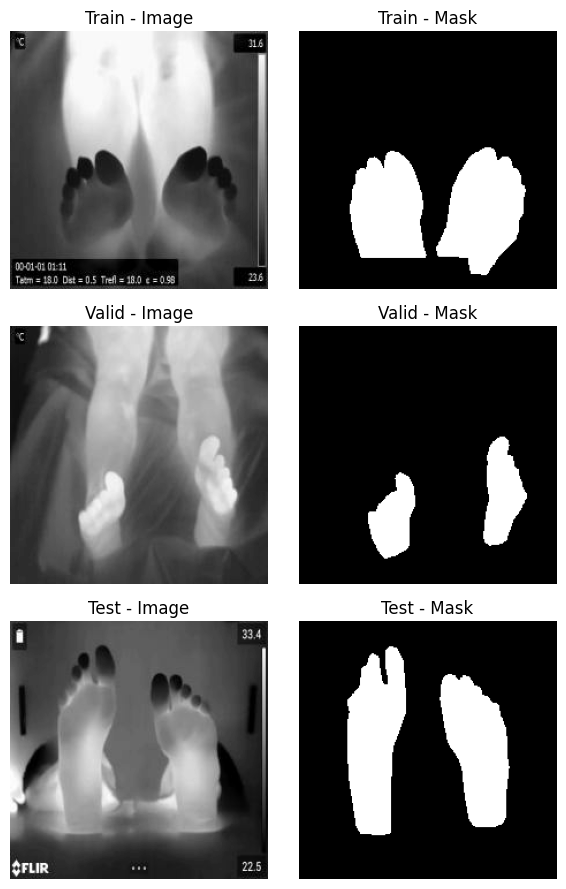

In [15]:
# Set the sample index
sample_index = 10

# Figure with 3 rows and 2 columns
fig, axes = plt.subplots(3, 2, figsize=(6, 9))

# Primera fila: Train
axes[0, 0].imshow(images_train[sample_index, ...], cmap='gray')
axes[0, 0].set_title("Train - Image")
axes[0, 0].axis('off')

axes[0, 1].imshow(masks_train[sample_index, ...], cmap='gray')
axes[0, 1].set_title("Train - Mask")
axes[0, 1].axis('off')

# Segunda fila: Valid
axes[1, 0].imshow(images_valid[sample_index, ...], cmap='gray')
axes[1, 0].set_title("Valid - Image")
axes[1, 0].axis('off')

axes[1, 1].imshow(masks_valid[sample_index, ...], cmap='gray')
axes[1, 1].set_title("Valid - Mask")
axes[1, 1].axis('off')

# Tercera fila: Test
axes[2, 0].imshow(images_test[sample_index, ...], cmap='gray')
axes[2, 0].set_title("Test - Image")
axes[2, 0].axis('off')

axes[2, 1].imshow(masks_test[sample_index, ...], cmap='gray')
axes[2, 1].set_title("Test - Mask")
axes[2, 1].axis('off')

# Set the space between subplots
plt.tight_layout()
plt.show()


## Loss function and Metrics Configuration

In [16]:
def _get_random_features_initializer(initializer, shape,seed): #Weights of convolutionn kernel in ConvRF
    def _get_cauchy_samples(loc, scale, shape):
        np.random.seed(seed)
        probs = np.random.uniform(low=0., high=1., size=shape)
        return loc + scale * np.tan(np.pi * (probs - 0.5))

    if isinstance(initializer,str):
        if initializer == "gaussian":
            return tf.keras.initializers.RandomNormal(mean=0.0,stddev=1.0,seed=seed)
        elif initializer == "laplacian":
            return tf.keras.initializers.Constant(
                _get_cauchy_samples(loc=0.0, scale=1.0, shape=shape))
        else:
            raise ValueError(f'Unsupported kernel initializer {initializer}')


class ConvRFF(tf.keras.layers.Layer):

    def __init__(self,output_dim, kernel_size=3,
                 scale=None,
                 trainable_scale=False, trainable_W=False,
                 kernel='gaussian',
                 padding='VALID',
                 stride=1,
                 kernel_regularizer=None,
                 normalization=True,
                 seed=None,
                 mass = False,
                 **kwargs):

        super(ConvRFF,self).__init__(**kwargs)

        self.output_dim = output_dim
        self.kernel_size = kernel_size
        self.scale = scale
        self.trainable_scale = trainable_scale
        self.trainable_W = trainable_W
        self.padding = padding
        self.stride = stride
        self.initializer = kernel
        self.kernel_regularizer = kernel_regularizer
        self.normalization = normalization
        self.seed = seed
        self.mass = mass


    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'output_dim': self.output_dim,
            'kernel_size': self.kernel_size,
            'scale': self.scale,
            'trainable_scale': self.trainable_scale,
            'trainable_W':self.trainable_W,
            'padding':self.padding,
            'kernel':self.initializer,
            'normalization':self.normalization,
            'seed' : self.seed,
            'mass': self.mass
        })
        return config


    def build(self,input_shape):
        input_dim = input_shape[-1]
        kernel_initializer = _get_random_features_initializer(self.initializer,
                                                              shape=(self.kernel_size,
                                                                     self.kernel_size,
                                                                     input_dim,
                                                                     self.output_dim),
                                                               seed=self.seed)

        self.kernel = self.add_weight(
            name='kernel',
            shape=(self.kernel_size,self.kernel_size,
                   input_dim,self.output_dim),
            dtype=tf.float32,
            initializer = kernel_initializer,
            trainable =self.trainable_W,
            regularizer = self.kernel_regularizer,
        )
        self.bias = self.add_weight(
            name='bias',
            shape=(self.output_dim,),
            dtype=tf.float32,
            initializer=tf.random_uniform_initializer(
                minval=0.0,maxval=2*np.pi,seed=self.seed),
            trainable=self.trainable_W
        )

        if not self.scale:
            if  self.initializer == 'gaussian':
                self.scale = np.sqrt((input_dim*self.kernel_size**2)/2.0)
            elif self.initializer == 'laplacian':
                self.scale = 1.0
            else:
                raise ValueError(f'Unsupported kernel initializer {self.initializer}')

        self.kernel_scale = self.add_weight(
            name='kernel_scale',
            shape=(1,),
            dtype=tf.float32,
            initializer=tf.compat.v1.constant_initializer(self.scale),
            trainable=self.trainable_scale,
            constraint='NonNeg'
        )


    def _compute_normal_probaility(self,x,mean,std):
        constant = 1/(tf.math.sqrt(2*np.pi)*std)
        return constant*tf.math.exp(-0.5*(x-mean)*(x-mean)/(std*std))


    def _compute_mass(self,):
        weights = tf.reshape(self.kernel,shape=(-1,self.output_dim))
        ww = tf.linalg.norm(weights,axis=0)
        ww_pos = tf.sort(ww)
        mean_pos = tf.reduce_mean(ww_pos)
        std_pos = tf.math.reduce_std(ww_pos)
        mass_pos = self._compute_normal_probaility(ww_pos,mean_pos,std_pos)
        mass_pos = tf.sqrt(tfp.math.trapz(tf.abs(mass_pos),ww_pos))
        return mass_pos


    def call(self,inputs):
        scale = tf.math.divide(1.0, self.kernel_scale)
        kernel = tf.math.multiply(scale,self.kernel)
        outputs = tf.nn.conv2d(inputs, kernel, strides=[1, self.stride, self.stride, 1], padding=self.padding)
        outputs = tf.nn.bias_add(outputs, self.bias)
        output_dim = tf.cast(self.output_dim, tf.float32)

        # Normalization in the outputs
        if self.normalization:
            outputs = tf.math.multiply(tf.math.sqrt(2 / output_dim), tf.cos(outputs))
        else:
            outputs = tf.cos(outputs)

        # Apply mass if is enabled
        outputs = tf.math.multiply(self._compute_mass(), outputs) if self.mass else outputs
        return outputs



def ConvRFF_block(x, deepth, mul_dim=3, name='01', trainable_W=True,
                  kernel_size=3, kernel_regularizer=None):

    phi_units = np.round(deepth*mul_dim).astype(np.uint32)
    x = ConvRFF(output_dim=phi_units, kernel_size=kernel_size,
                padding="SAME", trainable_scale=False,
                trainable_W=trainable_W, name=f'ConvRFF_{name}',
                mass=True,
                kernel_regularizer=kernel_regularizer)(x)
    return x

class DiceCoefficient(Loss):
    def __init__(self, smooth=1., target_class= None, name='DiceCoefficient', **kwargs):
        self.smooth = smooth
        self.target_class = target_class
        super().__init__(name=name,**kwargs)

    def call(self, y_true, y_pred):
        # Cuts the extreme values of y_pred
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)

        intersection = K.sum(y_true * y_pred, axis=[1, 2])
        union = K.sum(y_true, axis=[1, 2]) + K.sum(y_pred, axis=[1, 2])

        # Calculete the Dice Coefficient
        dice_coef = -(2. * intersection + self.smooth) / (union + self.smooth)

        # Selection of the objective class if specified
        if self.target_class is not None:
            dice_coef = tf.gather(dice_coef, self.target_class, axis=1)
        else:
            dice_coef = K.mean(dice_coef, axis=-1)

        return dice_coef

    def get_config(self,):
        base_config = super().get_config()
        return {**base_config, "smooth": self.smooth,
                "target_class":self.target_class}


class SparseCategoricalDiceCoefficient(DiceCoefficient):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, y_true, y_pred):
        y_true = to_categorical(y_true)
        return super().call(y_true, y_pred)

class Jaccard(Metric):

    def __init__(self,smooth=1.0, target_class=None, name='Jaccard',**kwargs):
        super().__init__(name=name, **kwargs)
        self.smooth = smooth
        self.target_class = target_class
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")


    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.compute(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.shape(y_true)[0], tf.float32))

    def result(self):
        return self.total/self.count

    def compute(self, y_true, y_pred):
        intersection = K.sum(y_true * y_pred, axis=[1,2])
        union = K.sum(y_true, axis=[1,2]) + K.sum(y_pred, axis=[1,2])
        jaccard = (intersection + self.smooth) / (union - intersection + self.smooth)

        if self.target_class != None:
            jaccard = tf.gather(jaccard,
                                self.target_class, axis=1)
        else:
            jaccard = K.mean(jaccard,axis=-1)

        return jaccard


    def get_config(self,):
        base_config = super().get_config()
        return {**base_config, "smooth": self.smooth,
                "target_class":self.target_class}


class SparseCategoricalJaccard(Jaccard):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = to_categorical(y_true)
        return super().update_state(y_true, y_pred)

class Sensitivity(Metric):

    def __init__(self, target_class=None, name='Sensitivity', **kwargs):
        super().__init__(name=name, **kwargs)
        self.target_class = target_class
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.sensitivity(y_true, y_pred, self.target_class)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.shape(y_true)[0], tf.float32))

    def result(self):
        return self.total/self.count

    def compute(self,y_true, y_pred):
        return self.sensitivity(y_true, y_pred, self.target_class)

    @staticmethod
    def sensitivity(y_true, y_pred, target_class=None):
        y_true = tf.cast(y_true > 0.5,tf.float32)
        y_pred = tf.cast(y_pred > 0.5 ,tf.float32)

        true_positves = K.sum(y_true*y_pred,axis=[1,2])
        total_positives = K.sum(y_true,axis=[1,2])

        sensitivity = true_positves / (total_positives + K.epsilon())

        if target_class != None:
            sensitivity = tf.gather(sensitivity,
                                    target_class, axis=1)
        else:
            sensitivity = K.mean(sensitivity,axis=-1)

        return sensitivity

    def get_config(self,):
        base_config = super().get_config()
        return {**base_config, "target_class":self.target_class}


class SparseCategoricalSensitivity(Sensitivity):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = to_categorical(y_true)
        return super().update_state(y_true, y_pred)

class Specificity(Metric):

    def __init__(self, target_class=None, name='Specificity',**kwargs):
        super().__init__(name=name, **kwargs)
        self.target_class = target_class
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.specificity(y_true, y_pred, self.target_class)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.shape(y_true)[0], tf.float32))

    def result(self):
        return self.total/self.count

    def compute(self,y_true, y_pred):
        return self.specificity(y_true, y_pred, self.target_class)

    @staticmethod
    def specificity(y_true, y_pred, target_class=None):
        y_true = tf.cast(y_true < 0.5,tf.float32)
        y_pred = tf.cast(y_pred < 0.5 ,tf.float32)

        return Sensitivity.sensitivity(y_true, y_pred, target_class)

    def get_config(self,):
        base_config = super().get_config()
        return {**base_config, "target_class":self.target_class}


class SparseCategoricalSpecificity(Specificity):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = to_categorical(y_true)
        return super().update_state(y_true, y_pred)

class DiceCoefficientMetric(Metric):

    def __init__(self,smooth=1.0, target_class=None, name='DiceCoefficientMetric',**kwargs):
        super().__init__(name=name,**kwargs)
        self.smooth = smooth
        self.target_class = target_class
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")


    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.compute(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.shape(y_true)[0], tf.float32))

    def result(self):
        return self.total/self.count

    def compute(self, y_true, y_pred):
        intersection = K.sum(y_true * y_pred, axis=[1,2])
        union = K.sum(y_true,axis=[1,2]) + K.sum(y_pred,axis=[1,2])
        dice_coef = -(2. * intersection + self.smooth) /(union + self.smooth)

        if self.target_class != None:
            dice_coef = tf.gather(dice_coef,
                                  self.target_class, axis=1)
        else:
            dice_coef = K.mean(dice_coef,axis=-1)

        return dice_coef

    def get_config(self,):
        base_config = super().get_config()
        return {**base_config, "smooth": self.smooth,
                "target_class":self.target_class}


class SparseCategoricalDiceCoefficientMetric(DiceCoefficientMetric):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = to_categorical(y_true)
        return super().update_state(y_true, y_pred)



# Define Jaccard Index (IoU)
def jaccard_index(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# Define Dice Coefficient
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Define Specificity
def specificity(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(K.round(y_pred))
    true_negatives = K.sum((1 - y_true_f) * (1 - y_pred_f))
    possible_negatives = K.sum(1 - y_true_f)
    return (true_negatives + smooth) / (possible_negatives + smooth)

# Define Sensitivity
def sensitivity(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(K.round(y_pred))
    true_positives = K.sum(y_true_f * y_pred_f)
    possible_positives = K.sum(y_true_f)
    return (true_positives + smooth) / (possible_positives + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1e-6  # A small value to prevent the Zero Division
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    union = K.sum(y_true, axis=-1) + K.sum(y_pred, axis=-1)
    dice_score = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice_score  # returns 1 - dice_score to minimize

def combined_loss(y_true, y_pred):
    alpha = 0.3  # Weight for Dice Loss
    beta = 0.8  # Weight for CrossEntropy
    dice_loss = DiceCoefficient()(y_true, y_pred)
    ce_loss = tf.keras.losses.CategoricalCrossentropy()(y_true, y_pred)
    return alpha * dice_loss + beta * ce_loss

## Compile the Models

### Model 1 with Dice Loss

**Dice Loss** is a loss function commonly used in image segmentation tasks. It measures the overlap between the predicted segmentation and the ground truth. By maximizing the Dice coefficient, the model optimizes the similarity between predicted and true regions. Dice Loss is particularly effective for imbalanced datasets where certain classes or regions are underrepresented.

The formula for the Dice Loss is:

$$
\text{Dice Loss} = 1 - \frac{2 \sum_{i=1}^N p_i g_i}{\sum_{i=1}^N p_i^2 + \sum_{i=1}^N g_i^2 + \epsilon}
$$

Where:
- $p_i$: predicted value for the $i$-th pixel (or voxel).
- $g_i$: ground truth value for the $i$-th pixel (or voxel).
- $N$: total number of pixels (or voxels).
- $\epsilon$: small constant to avoid division by zero.

---


In [13]:
# Distribution strategy
strategy = tf.distribute.MirroredStrategy()

# Create the model within the context of the strategy
with strategy.scope():

    with tf.keras.utils.custom_object_scope({'ConvRFF': ConvRFF, 'DiceCoefficient': DiceCoefficient, 'Jaccard': Jaccard, 'Sensitivity': Sensitivity, 'Specificity': Specificity, 'DiceCoefficientMetric': DiceCoefficientMetric}):
        model_dice = tf.keras.models.load_model('model-best.h5')
    
    # Compile the model
    model_dice.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss = dice_loss,
        metrics=[
            jaccard_index,
            dice_coefficient,
            specificity,
            sensitivity
        ]
    )

### Model 2 with Categorical Cross Entropy Loss

**Categorical Cross-Entropy (CCE)** is a loss function used for multi-class classification tasks. It measures the dissimilarity between the predicted probability distribution and the true distribution (one-hot encoded labels). The goal is to minimize this loss to increase the likelihood of the correct class predictions.

The formula for Categorical Cross-Entropy is:

$$
\text{CCE Loss} = -\frac{1}{N} \sum_{i=1}^N \sum_{c=1}^C y_{i,c} \log(\hat{y}_{i,c})
$$

Where:
- $N$: number of samples.
- $C$: number of classes.
- $ y_{i,c}$: binary indicator (1 if class $c$ is the correct class for sample $i$, 0 otherwise).
- $\hat{y}_{i,c}$: predicted probability for class $c$ of sample $i$.

---

In [14]:
# Distribution strategy
strategy1 = tf.distribute.MirroredStrategy()
# Create the model within the context of the strategy
with strategy1.scope():

    with tf.keras.utils.custom_object_scope({'ConvRFF': ConvRFF, 'DiceCoefficient': DiceCoefficient, 'Jaccard': Jaccard, 'Sensitivity': Sensitivity, 'Specificity': Specificity, 'DiceCoefficientMetric': DiceCoefficientMetric}):
        model_cross_entropy = tf.keras.models.load_model('model-best.h5')
    
    model_cross_entropy.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss = 'categorical_crossentropy',
        metrics=[
            jaccard_index,
            dice_coefficient,
            specificity,
            sensitivity
        ]
    )

## Model 3 with Combined Loss

**Combined Loss Function**  
This loss function is a weighted combination of **Dice Loss** and **Categorical Cross-Entropy Loss (CCE)**. It leverages the strengths of both metrics:  
- **Dice Loss** focuses on optimizing the overlap between predicted and true regions, making it particularly suitable for imbalanced data.  
- **Categorical Cross-Entropy Loss** ensures accurate class predictions by penalizing incorrect probabilities in multi-class settings.

The formula for the combined loss is:  
$$
\text{Combined Loss} = \alpha \cdot \text{Dice Loss} + \beta \cdot \text{CCE Loss}
$$

Where:
- $\alpha$ and $\beta$ are the weights assigned to the Dice Loss and CCE Loss, respectively.
- Dice Loss is calculated as:
  $$
  \text{Dice Loss} = 1 - \frac{2 \cdot \sum y_{\text{true}} \cdot y_{\text{pred}} + \epsilon}{\sum y_{\text{true}} + \sum y_{\text{pred}} + \epsilon}
  $$
- CCE Loss is calculated as:
  $$
  \text{CCE Loss} = -\frac{1}{N} \sum_{i=1}^N \sum_{c=1}^C y_{i,c} \log(\hat{y}_{i,c})
  $$


Here the values of $\alpha$ and $\beta$ are:
- $\alpha$ = 0.3
- $\beta$ = 0.8


---

In [15]:
with tf.keras.utils.custom_object_scope({'ConvRFF': ConvRFF, 'DiceCoefficient': DiceCoefficient, 'Jaccard': Jaccard, 'Sensitivity': Sensitivity, 'Specificity': Specificity, 'DiceCoefficientMetric': DiceCoefficientMetric}):
    model_combined_Loss = tf.keras.models.load_model('model-best.h5')


model_combined_Loss.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss = combined_loss,
    metrics=[
        jaccard_index,
        dice_coefficient,
        specificity,
        sensitivity
    ]
)

### Summary of each model

In [16]:
model_dice.summary()

Model: "UNET_RFF"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 Batch00 (BatchNormalizatio  (None, 224, 224, 1)          4         ['input_4[0][0]']             
 n)                                                                                               
                                                                                                  
 Conv10 (Conv2D)             (None, 224, 224, 8)          80        ['Batch00[0][0]']             
                                                                                                  
 Batch10 (BatchNormalizatio  (None, 224, 224, 8)          32        ['Conv10[0][0]']       

In [17]:
model_cross_entropy.summary()

Model: "UNET_RFF"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 Batch00 (BatchNormalizatio  (None, 224, 224, 1)          4         ['input_4[0][0]']             
 n)                                                                                               
                                                                                                  
 Conv10 (Conv2D)             (None, 224, 224, 8)          80        ['Batch00[0][0]']             
                                                                                                  
 Batch10 (BatchNormalizatio  (None, 224, 224, 8)          32        ['Conv10[0][0]']       

In [18]:
model_combined_Loss.summary()

Model: "UNET_RFF"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 1)]        0         []                            
                                                                                                  
 Batch00 (BatchNormalizatio  (None, 224, 224, 1)          4         ['input_4[0][0]']             
 n)                                                                                               
                                                                                                  
 Conv10 (Conv2D)             (None, 224, 224, 8)          80        ['Batch00[0][0]']             
                                                                                                  
 Batch10 (BatchNormalizatio  (None, 224, 224, 8)          32        ['Conv10[0][0]']       

## Fit the models

In [19]:
history_dice = model_dice.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=50)

Epoch 1/50


I0000 00:00:1741050135.162063     231 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


16/16 [==============================] - 39s 507ms/step - loss: 0.6724 - jaccard_index: 0.6274 - dice_coefficient: 0.7480 - specificity: 0.8189 - sensitivity: 0.9716 - val_loss: 0.4307 - val_jaccard_index: 0.4950 - val_dice_coefficient: 0.6518 - val_specificity: 0.6915 - val_sensitivity: 0.9424
Epoch 2/50
16/16 [==============================] - 1s 83ms/step - loss: 0.4960 - jaccard_index: 0.4225 - dice_coefficient: 0.5754 - specificity: 0.5931 - sensitivity: 0.9783 - val_loss: 0.5361 - val_jaccard_index: 0.3248 - val_dice_coefficient: 0.4825 - val_specificity: 0.3517 - val_sensitivity: 0.9868
Epoch 3/50
16/16 [==============================] - 1s 77ms/step - loss: 0.4246 - jaccard_index: 0.4011 - dice_coefficient: 0.5560 - specificity: 0.5432 - sensitivity: 0.9910 - val_loss: 0.4747 - val_jaccard_index: 0.3495 - val_dice_coefficient: 0.5098 - val_specificity: 0.4148 - val_sensitivity: 0.9987
Epoch 4/50
16/16 [==============================] - 1s 77ms/step - loss: 0.3933 - jaccard_inde

In [20]:
history_cross_entropy = model_cross_entropy.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=50)

Epoch 1/50
16/16 [==============================] - 26s 203ms/step - loss: 0.0000e+00 - jaccard_index: 0.7421 - dice_coefficient: 0.8393 - specificity: 0.9346 - sensitivity: 0.9116 - val_loss: 0.0000e+00 - val_jaccard_index: 0.8083 - val_dice_coefficient: 0.8892 - val_specificity: 0.9565 - val_sensitivity: 0.9300
Epoch 2/50
16/16 [==============================] - 1s 83ms/step - loss: 0.0000e+00 - jaccard_index: 0.7040 - dice_coefficient: 0.8192 - specificity: 0.9376 - sensitivity: 0.8886 - val_loss: 0.0000e+00 - val_jaccard_index: 0.7652 - val_dice_coefficient: 0.8651 - val_specificity: 0.9356 - val_sensitivity: 0.9462
Epoch 3/50
16/16 [==============================] - 1s 80ms/step - loss: 0.0000e+00 - jaccard_index: 0.8013 - dice_coefficient: 0.8861 - specificity: 0.9663 - sensitivity: 0.9271 - val_loss: 0.0000e+00 - val_jaccard_index: 0.8664 - val_dice_coefficient: 0.9279 - val_specificity: 0.9765 - val_sensitivity: 0.9431
Epoch 4/50
16/16 [==============================] - 1s 80ms

In [21]:
history_combined_loss = model_combined_Loss.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=50)

Epoch 1/50
16/16 [==============================] - 23s 226ms/step - loss: -0.2597 - jaccard_index: 0.7734 - dice_coefficient: 0.8641 - specificity: 0.9408 - sensitivity: 0.9367 - val_loss: -0.2721 - val_jaccard_index: 0.8420 - val_dice_coefficient: 0.9131 - val_specificity: 0.9705 - val_sensitivity: 0.9318
Epoch 2/50
16/16 [==============================] - 2s 99ms/step - loss: -0.2489 - jaccard_index: 0.7191 - dice_coefficient: 0.8348 - specificity: 0.9600 - sensitivity: 0.8464 - val_loss: -0.2782 - val_jaccard_index: 0.8763 - val_dice_coefficient: 0.9337 - val_specificity: 0.9774 - val_sensitivity: 0.9467
Epoch 3/50
16/16 [==============================] - 2s 99ms/step - loss: -0.2668 - jaccard_index: 0.8055 - dice_coefficient: 0.8895 - specificity: 0.9655 - sensitivity: 0.9302 - val_loss: -0.2820 - val_jaccard_index: 0.8943 - val_dice_coefficient: 0.9441 - val_specificity: 0.9789 - val_sensitivity: 0.9635
Epoch 4/50
16/16 [==============================] - 2s 100ms/step - loss: -0.

### Save each Model to download

In [20]:
model_dice.save('modelo_DiceLoss.h5')
model_cross_entropy.save('modelo_CrossEntropy.h5')
model_combined_Loss.save('modelo_DiceCross.h5')

In [21]:
FileLink('modelo_DiceLoss.h5')

/kaggle/working/modelo_DiceLoss.h5

In [22]:
FileLink('modelo_CrossEntropy.h5')

/kaggle/working/modelo_CrossEntropy.h5

In [23]:
FileLink('modelo_DiceCross.h5')

/kaggle/working/modelo_DiceCross.h5

## Loss Function Graph

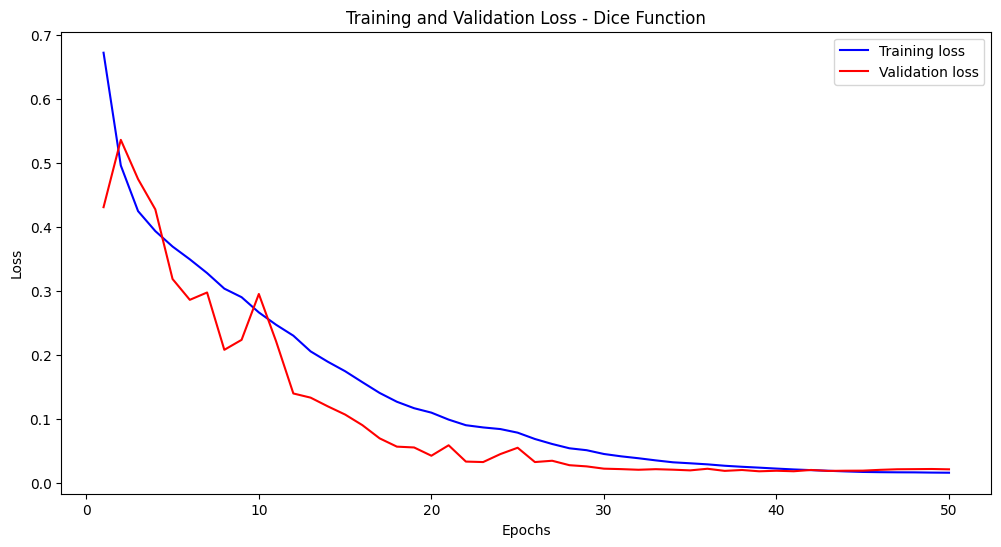

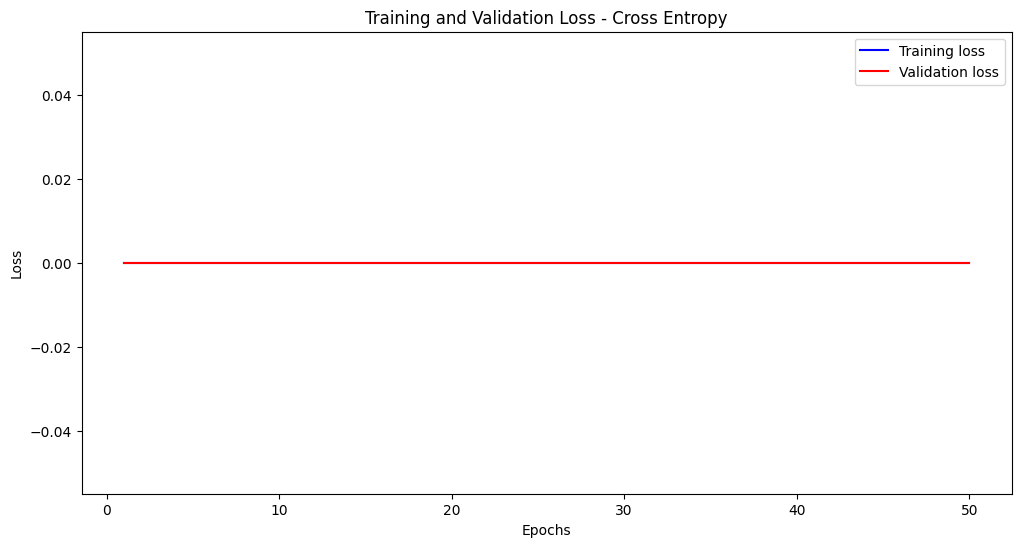

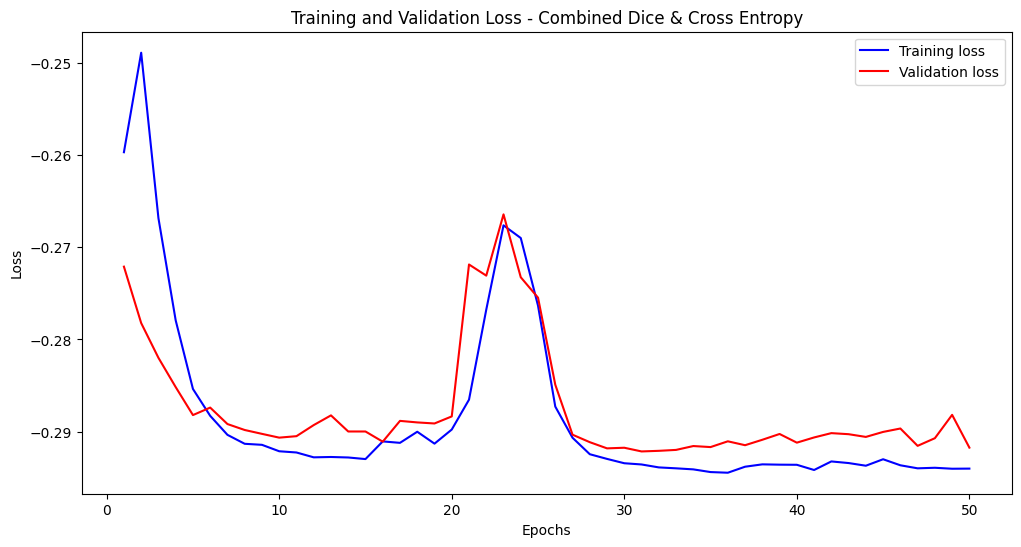

In [23]:
# Extract loss values
train_loss_dice = history_dice.history['loss']
val_loss_dice = history_dice.history['val_loss']

train_loss_cross_entropy = history_cross_entropy.history['loss']
val_loss_cross_entropy = history_cross_entropy.history['val_loss']

train_loss_combined = history_combined_loss.history['loss']
val_loss_combined = history_combined_loss.history['val_loss']


# Create a list with the number of epochs
epochs_dice = range(1, len(train_loss_dice) + 1)
epochs_cross = range(1, len(train_loss_cross_entropy) + 1)
epochs_combined = range(1, len(train_loss_combined) + 1)

# Create the chart

plt.figure(figsize=(12,6))
plt.plot(epochs_dice, train_loss_dice, 'b', label='Training loss')
plt.plot(epochs_dice, val_loss_dice, 'r', label='Validation loss')
plt.title('Training and Validation Loss - Dice Function')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.figure(figsize=(12,6))
plt.plot(epochs_cross, train_loss_cross_entropy, 'b', label='Training loss')
plt.plot(epochs_cross, val_loss_cross_entropy, 'r', label='Validation loss')
plt.title('Training and Validation Loss - Cross Entropy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


plt.figure(figsize=(12,6))
plt.plot(epochs_combined, train_loss_combined, 'b', label='Training loss')
plt.plot(epochs_combined, val_loss_combined, 'r', label='Validation loss')
plt.title('Training and Validation Loss - Combined Dice & Cross Entropy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Load the Downloaded Models

In [5]:
!cp -r /kaggle/input/model-segmentation/modelo_DiceLoss.h5 /kaggle/working/
!cp -r /kaggle/input/model-segmentation/modelo_CrossEntropy.h5 /kaggle/working/
!cp -r /kaggle/input/model-segmentation/modelo_DiceCross.h5 /kaggle/working/

In [17]:
with tf.keras.utils.custom_object_scope({'ConvRFF': ConvRFF, 'dice_loss': dice_loss, 'jaccard_index': jaccard_index, 'sensitivity': sensitivity, 'specificity': specificity, 'dice_coefficient': dice_coefficient}):
    model_dice = load_model('modelo_DiceLoss.h5')

with tf.keras.utils.custom_object_scope({'ConvRFF': ConvRFF, 'jaccard_index': jaccard_index, 'sensitivity': sensitivity, 'specificity': specificity, 'dice_coefficient': dice_coefficient}):
    model_cross_entropy = load_model('modelo_CrossEntropy.h5')

with tf.keras.utils.custom_object_scope({'ConvRFF': ConvRFF, 'combined_loss': combined_loss, 'jaccard_index': jaccard_index, 'sensitivity': sensitivity, 'specificity': specificity, 'dice_coefficient': dice_coefficient}):
    model_combined_Loss = load_model('modelo_DiceCross.h5')

## Making the Inference

In [18]:
pred_dice = model_dice.predict(images_test)

pred_CE = model_cross_entropy.predict(images_test)

pred_combined = model_combined_Loss.predict(images_test)

1/1 [==============================] - 1s 612ms/step


## Showing Normal, Good and Bad Samples for each Model

### Normal Sample

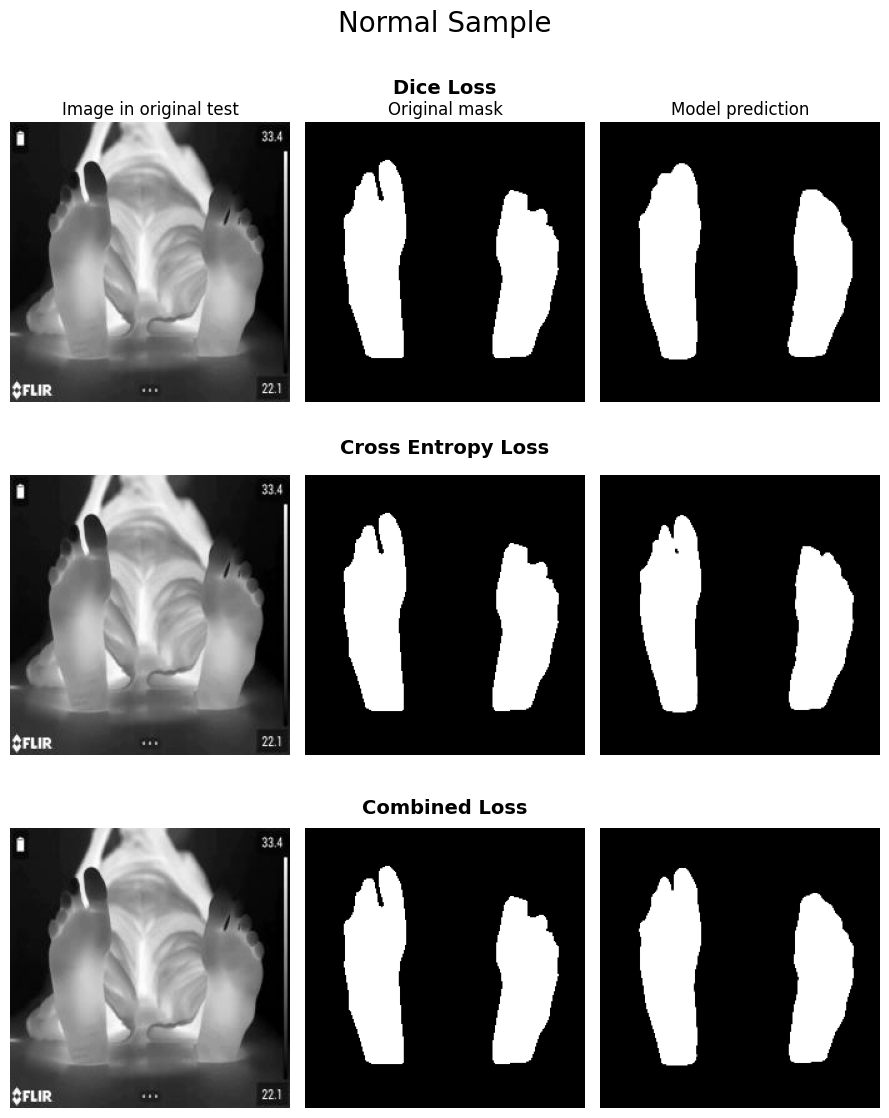

In [19]:
# Configure Index of the sample
sample_index = 11


fig, axes = plt.subplots(3, 3, figsize=(9, 12))


axes[0, 0].imshow(images_test[sample_index, ...], cmap='gray')
axes[0, 0].set_title("Image in original test")
axes[0, 0].axis('off')

axes[0, 1].imshow(masks_test[sample_index], cmap='gray')
axes[0, 1].set_title('Original mask')
axes[0, 1].axis('off')

axes[0, 2].imshow(pred_dice[sample_index], cmap='gray')
axes[0, 2].set_title('Model prediction')
axes[0, 2].axis('off')


axes[1, 0].imshow(images_test[sample_index, ...], cmap='gray')
axes[1, 0].axis('off')

axes[1, 1].imshow(masks_test[sample_index], cmap='gray')
axes[1, 1].axis('off')

axes[1, 2].imshow(pred_CE[sample_index], cmap='gray')
axes[1, 2].axis('off')


axes[2, 0].imshow(images_test[sample_index, ...], cmap='gray')
axes[2, 0].axis('off')

axes[2, 1].imshow(masks_test[sample_index], cmap='gray')
axes[2, 1].axis('off')

axes[2, 2].imshow(pred_combined[sample_index], cmap='gray')
axes[2, 2].axis('off')


fig.text(0.5, 0.91, 'Dice Loss', ha='center', fontsize=14, fontweight='bold')
fig.text(0.5, 0.61, 'Cross Entropy Loss', ha='center', fontsize=14, fontweight='bold')
fig.text(0.5, 0.31, 'Combined Loss', ha='center', fontsize=14, fontweight='bold')


plt.tight_layout(rect=[0, 0, 1, 0.95])  # Space between titles
fig.suptitle("Normal Sample", fontsize=20)
plt.show()

### Good Sample

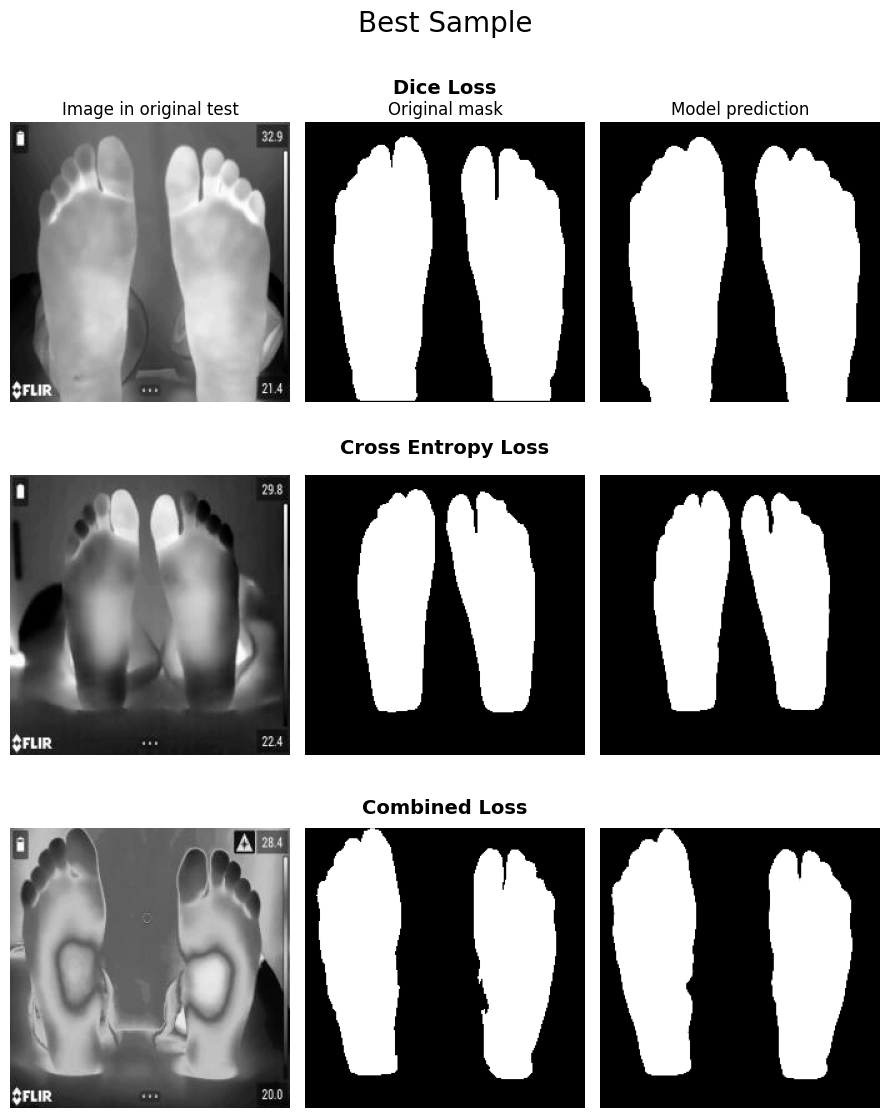

In [20]:
sample_dice = 14  
sample_CE = 7
sample_combined = 13

fig, axes = plt.subplots(3, 3, figsize=(9, 12)) 

axes[0, 0].imshow(images_test[sample_dice, ...], cmap='gray')
axes[0, 0].set_title("Image in original test")
axes[0, 0].axis('off')

axes[0, 1].imshow(masks_test[sample_dice], cmap='gray')
axes[0, 1].set_title('Original mask')
axes[0, 1].axis('off')

axes[0, 2].imshow(pred_dice[sample_dice], cmap='gray')
axes[0, 2].set_title('Model prediction')
axes[0, 2].axis('off')

axes[1, 0].imshow(images_test[sample_CE, ...], cmap='gray')
axes[1, 0].axis('off')

axes[1, 1].imshow(masks_test[sample_CE], cmap='gray')
axes[1, 1].axis('off')

axes[1, 2].imshow(pred_CE[sample_CE], cmap='gray')
axes[1, 2].axis('off')

axes[2, 0].imshow(images_test[sample_combined, ...], cmap='gray')
axes[2, 0].axis('off')

axes[2, 1].imshow(masks_test[sample_combined], cmap='gray')
axes[2, 1].axis('off')

axes[2, 2].imshow(pred_combined[sample_combined], cmap='gray')
axes[2, 2].axis('off')

fig.text(0.5, 0.91, 'Dice Loss', ha='center', fontsize=14, fontweight='bold')
fig.text(0.5, 0.61, 'Cross Entropy Loss', ha='center', fontsize=14, fontweight='bold')
fig.text(0.5, 0.31, 'Combined Loss', ha='center', fontsize=14, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.suptitle("Best Sample", fontsize=20)
plt.show()


### Bad Sample

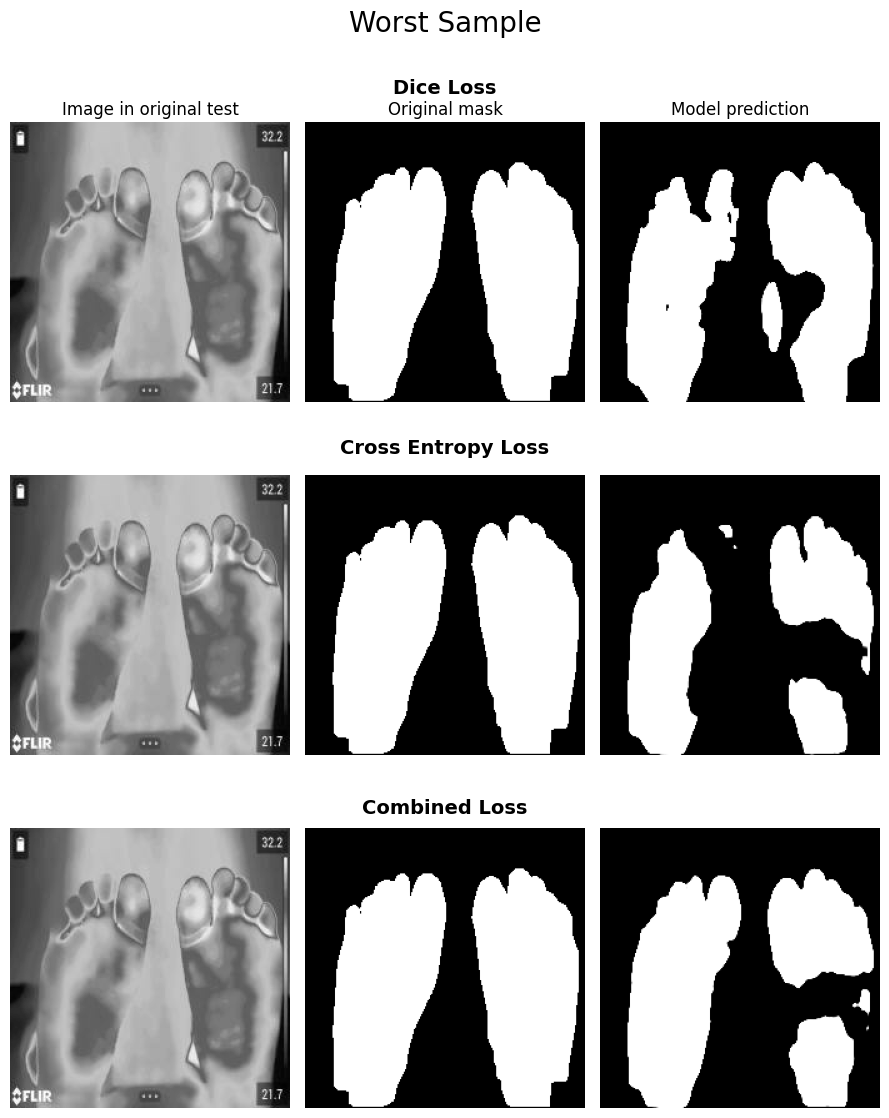

In [21]:
sample_dice = 15
sample_CE = 15
sample_combined = 15

fig, axes = plt.subplots(3, 3, figsize=(9, 12))

axes[0, 0].imshow(images_test[sample_dice, ...], cmap='gray')
axes[0, 0].set_title("Image in original test")
axes[0, 0].axis('off')

axes[0, 1].imshow(masks_test[sample_dice], cmap='gray')
axes[0, 1].set_title('Original mask')
axes[0, 1].axis('off')

axes[0, 2].imshow(pred_dice[sample_dice], cmap='gray')
axes[0, 2].set_title('Model prediction')
axes[0, 2].axis('off')

axes[1, 0].imshow(images_test[sample_CE, ...], cmap='gray')
axes[1, 0].axis('off')

axes[1, 1].imshow(masks_test[sample_CE], cmap='gray')
axes[1, 1].axis('off')

axes[1, 2].imshow(pred_CE[sample_CE], cmap='gray')
axes[1, 2].axis('off')

axes[2, 0].imshow(images_test[sample_combined, ...], cmap='gray')
axes[2, 0].axis('off')

axes[2, 1].imshow(masks_test[sample_combined], cmap='gray')
axes[2, 1].axis('off')

axes[2, 2].imshow(pred_combined[sample_combined], cmap='gray')
axes[2, 2].axis('off')

fig.text(0.5, 0.91, 'Dice Loss', ha='center', fontsize=14, fontweight='bold')
fig.text(0.5, 0.61, 'Cross Entropy Loss', ha='center', fontsize=14, fontweight='bold')
fig.text(0.5, 0.31, 'Combined Loss', ha='center', fontsize=14, fontweight='bold')

plt.tight_layout(rect=[0, 0, 1, 0.95])
fig.suptitle("Worst Sample", fontsize=20)
plt.show()


## Best Model

### IoU metric

$$\text{IoU} = \frac{\sum_{i} y_{\text{true}}[i] \times y_{\text{pred}}[i]}{\sum_{i} y_{\text{true}}[i] + y_{\text{pred}}[i] - \sum_{i} y_{\text{true}}[i] \times y_{\text{pred}}[i]}$$


Jaccard function

In [30]:
# Definition of the Jaccarmodel_y_test jaccard_metric(y_true, y_pred, axis=(1,2), smooth=1e-5, num_annotators=3):
def jaccard_metric(y_true, y_pred, axis=(1, 2), smooth=1e-5, num_annotators=3):
    """Computes the Jaccard similarity coefficient as a metric for semantic segmentation.

    The Jaccard similarity coefficient, also known as the Intersection over Union (IoU),
    measures the similarity between two sets by comparing their intersection to their union.
    In the context of semantic segmentation, it quantifies the overlap between the ground
    truth segmentation masks and the predicted segmentation masks.

    Parameters:
        y_true (tensor): Ground truth segmentation masks.
        y_pred (tensor): Predicted segmentation masks.
        axis (tuple of int): Axes along which to compute sums. Defaults to (1, 2).
        smooth (float): A small smoothing parameter to avoid division by zero. Defaults to 1e-5.
        num_annotators (int): Number of annotators. Defaults to 3.

    Returns:
        A tensor representing the mean Jaccard similarity coefficient.

    """ 
    y_true = tf.cast(tf.squeeze(y_true, axis=-1), tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred = tf.where(y_pred> 0.5, tf.ones_like(y_pred), tf.zeros_like(y_pred))
    intersection = tf.reduce_sum(y_true * y_pred, axis=axis)
    union = tf.reduce_sum(y_true, axis=axis) + tf.reduce_sum(y_pred, axis=axis) - intersection
    jaccard = (intersection + smooth) / (union + smooth)
    return tf.reduce_mean(jaccard)


# Definition of Jaccard metric for single samples

def jaccard_metric_single(y_true, y_pred, smooth=1e-5):
    
    y_true = tf.cast(tf.squeeze(y_true), tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    
    y_pred = tf.where(y_pred > 0.5, tf.ones_like(y_pred), tf.zeros_like(y_pred))
    
    
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    
    
    jaccard = (intersection + smooth) / (union + smooth)
    return jaccard

### Jaccard for each model

In [31]:
iou_dice = jaccard_metric(masks_test,pred_dice[:,:,:,0])
iou_CE = jaccard_metric(masks_test,pred_CE[:,:,:,0])
iou_combined = jaccard_metric(masks_test,pred_combined[:,:,:,0])

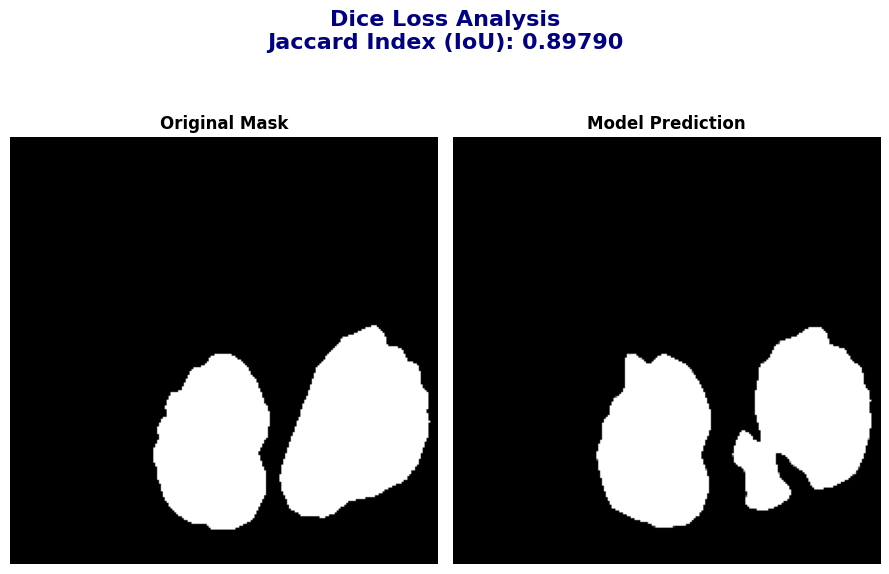

In [32]:
sample_index = 0

fig, axes = plt.subplots(1, 2, figsize=(9, 6))

axes[0].imshow(masks_test[sample_index], cmap='gray')
axes[0].set_title('Original Mask', fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(pred_dice[sample_index], cmap='gray')
axes[1].set_title('Model Prediction', fontsize=12, fontweight='bold')
axes[1].axis('off')

fig.suptitle(f"Dice Loss Analysis\nJaccard Index (IoU): {iou_dice:.5f}", 
             fontsize=16, fontweight='bold', color='navy')

# Space between titles
plt.tight_layout(rect=[0, 0, 1, 0.92])

plt.show()

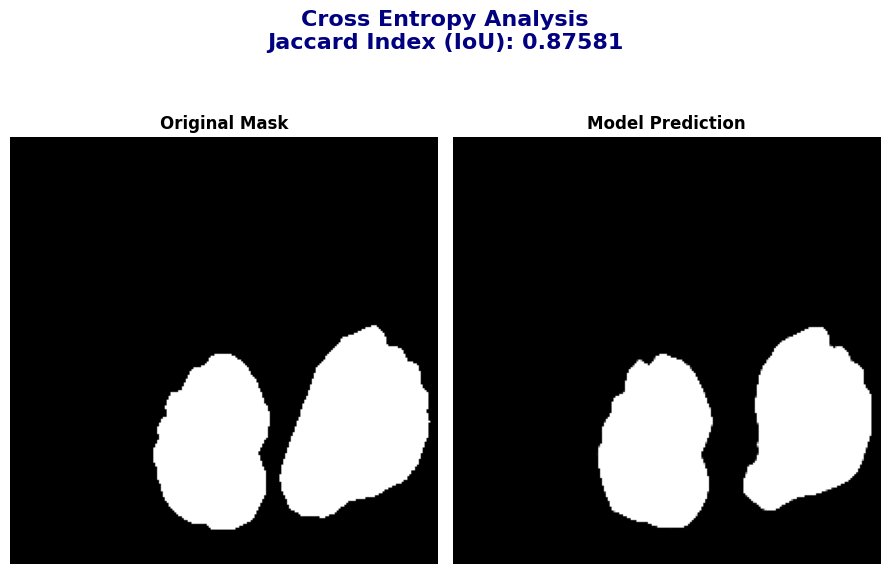

In [33]:
sample_index = 0

fig, axes = plt.subplots(1, 2, figsize=(9, 6))

axes[0].imshow(masks_test[sample_index], cmap='gray')
axes[0].set_title('Original Mask', fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(pred_CE[sample_index], cmap='gray')
axes[1].set_title('Model Prediction', fontsize=12, fontweight='bold')
axes[1].axis('off')

fig.suptitle(f"Cross Entropy Analysis\nJaccard Index (IoU): {iou_CE:.5f}", 
             fontsize=16, fontweight='bold', color='navy')

# Space between titles
plt.tight_layout(rect=[0, 0, 1, 0.92])

plt.show()

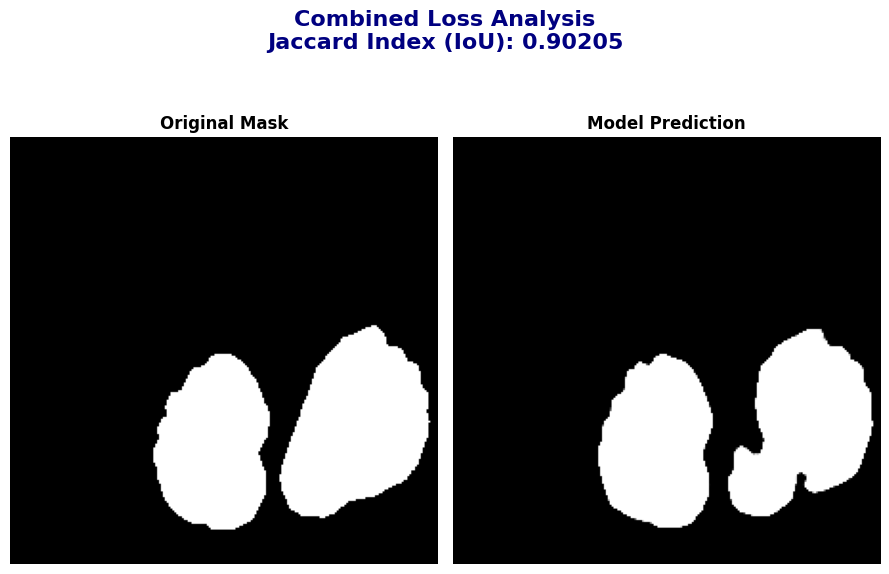

In [34]:
sample_index = 0

fig, axes = plt.subplots(1, 2, figsize=(9, 6))

axes[0].imshow(masks_test[sample_index], cmap='gray')
axes[0].set_title('Original Mask', fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(pred_combined[sample_index], cmap='gray')
axes[1].set_title('Model Prediction', fontsize=12, fontweight='bold')
axes[1].axis('off')

fig.suptitle(f"Combined Loss Analysis\nJaccard Index (IoU): {iou_combined:.5f}", 
             fontsize=16, fontweight='bold', color='navy')

# Space between titles
plt.tight_layout(rect=[0, 0, 1, 0.92])

plt.show()

# T Student

In [35]:
# Calculate IoU for each test mask
ious_dice = [jaccard_metric_single(masks_test[i], pred_dice[i, :, :, 0]).numpy() for i in range(masks_test.shape[0])]
ious_CE = [jaccard_metric_single(masks_test[i], pred_CE[i, :, :, 0]).numpy() for i in range(masks_test.shape[0])]
ious_combined = [jaccard_metric_single(masks_test[i], pred_combined[i, :, :, 0]).numpy() for i in range(masks_test.shape[0])]

In [37]:
avg_dice = np.mean(ious_dice)
std_dice = np.std(ious_dice)

avg_CE = np.mean(ious_CE)
std_CE = np.std(ious_CE)

avg_combined = np.mean(ious_combined)
std_combined = np.std(ious_combined)

_, p_dice_CE = ttest_ind(ious_dice, ious_CE)
_, p_dice_combined = ttest_ind(ious_dice, ious_combined)
_, p_CE_combined = ttest_ind(ious_CE, ious_combined)


data = {
    "Model": ["Dice", "CrossEntropy", "Combined"],
    "Mean IoU": [avg_dice, avg_CE, avg_combined],
    "Std Dev": [std_dice, std_CE, std_combined],
    "p-value vs Dice": [None, p_dice_CE, p_dice_combined],
    "p-value vs CrossEntropy": [p_dice_CE, None, p_CE_combined],
    "p-value vs Combined": [p_dice_combined, p_CE_combined, None],
}

df = pd.DataFrame(data)
df

,Model,Mean IoU,Std Dev,p-value vs Dice,p-value vs CrossEntropy,p-value vs Combined
0,Dice,0.897898,0.146535,NaN,0.736291,0.939139
1,CrossEntropy,0.875814,0.204561,0.736291,NaN,0.690729
2,Combined,0.902049,0.148751,0.939139,0.690729,NaN


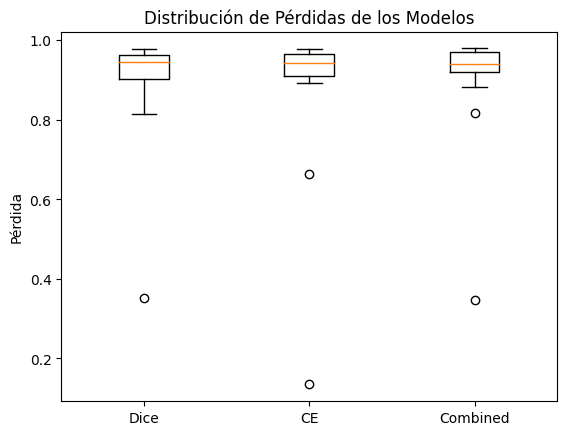

In [38]:
# Graph for losses
plt.boxplot([ious_dice,ious_CE,ious_combined], labels=["Dice", "CE", "Combined"])
plt.title("Distribución de Pérdidas de los Modelos")
plt.ylabel("Pérdida")
plt.show()

### Dice Metric

The Dice metric, also known as the Dice Similarity Coefficient (DSC), is an overlap measure used to evaluate the similarity between two sets, commonly applied in image segmentation tasks. It ranges from 0 to 1, where a value closer to 1 indicates greater similarity between the predicted segmentation and the ground truth.

$$
\text{Dice} = \frac{2 \cdot |\text{A} \cap \text{B}|}{|\text{A}| + |\text{B}|} = \frac{2 \cdot \sum_i \left( y_{\text{true}}^i \cdot y_{\text{pred}}^i \right)}{\sum_i y_{\text{true}}^i + \sum_i y_{\text{pred}}^i}
$$

Description of the Terms:


- $ y_{\text{true}}^i $: Ground truth value at pixel \(i\).
- $ y_{\text{pred}}^i $: Predicted value at pixel \(i\).
- $ \sum_i $: Summation over all pixels in the image.
- $ |\text{A}| $: Number of elements in set \(A\) (ground truth).
- $ |\text{B}| $: Number of elements in set \(B\) (prediction). 

---

This metric is especially useful in medical image segmentation as it balances the penalties for false positives and false negatives, providing a reliable measure of model performance.

In [22]:
def dice_metric(y_true, y_pred, axis=(1, 2), smooth=1e-5):
    """Computes the Dice coefficient metric for evaluating semantic segmentation.

    This function calculates the Dice coefficient metric, which measures the similarity
    between ground truth and predicted segmentation masks.

    Parameters:
        y_true (tensor): Ground truth segmentation masks.
        y_pred (tensor): Predicted segmentation masks.
        axis (tuple of int): Axis along which to compute sums. Defaults to (1, 2).
        smooth (float): A smoothing parameter to avoid division by zero. Defaults to 1e-5.
        num_annotators (int): Number of annotators. Defaults to 3.

    Returns:
        A scalar value representing the average Dice coefficient metric.
    """
    y_true = tf.cast(tf.squeeze(y_true, axis=-1), tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred = tf.where(y_pred> 0.5, tf.ones_like(y_pred), tf.zeros_like(y_pred))
    intersection = tf.reduce_sum(y_true * y_pred, axis=axis)
    union = tf.reduce_sum(y_true, axis=axis) + tf.reduce_sum(y_pred, axis=axis)
    dice = (2. * intersection + smooth) / (union + smooth)
    return tf.reduce_mean(dice)

def dice_metric_single(y_true, y_pred, smooth=1e-5):
    # Tensors with same shape
    y_true = tf.cast(tf.squeeze(y_true), tf.float32)  # Remove extra channels
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Umbralization of the prediction
    y_pred = tf.where(y_pred > 0.5, tf.ones_like(y_pred), tf.zeros_like(y_pred))
    
    # Calculate intersection and union
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    
    # Dice Metric
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

In [23]:
dice_dice = dice_metric(masks_test,pred_dice[:,:,:,0])
dice_CE = dice_metric(masks_test,pred_CE[:,:,:,0])
dice_combined = dice_metric(masks_test,pred_combined[:,:,:,0])

print(dice_dice)
print(dice_CE)
print(dice_combined)

tf.Tensor(0.9377458, shape=(), dtype=float32)
tf.Tensor(0.914264, shape=(), dtype=float32)
tf.Tensor(0.9397916, shape=(), dtype=float32)


In [24]:
# Calculate Dice for each test mask
dices_dice = [dice_metric_single(masks_test[i], pred_dice[i, :, :, 0]).numpy() for i in range(masks_test.shape[0])]
dices_CE = [dice_metric_single(masks_test[i], pred_CE[i, :, :, 0]).numpy() for i in range(masks_test.shape[0])]
dices_combined = [dice_metric_single(masks_test[i], pred_combined[i, :, :, 0]).numpy() for i in range(masks_test.shape[0])]

In [25]:
avg_dice = np.mean(dices_dice)
std_dice = np.std(dices_dice)

avg_CE = np.mean(dices_CE)
std_CE = np.std(dices_CE)

avg_combined = np.mean(dices_combined)
std_combined = np.std(dices_combined)

_, p_dice_CE = ttest_ind(dices_dice, dices_CE)
_, p_dice_combined = ttest_ind(dices_dice, dices_combined)
_, p_CE_combined = ttest_ind(dices_CE, dices_combined)

data = {
    "Model": ["Dice", "CrossEntropy", "Combined"],
    "Mean Dice": [avg_dice, avg_CE, avg_combined],
    "Std Dev": [std_dice, std_CE, std_combined],
    "p-value vs Dice": [None, p_dice_CE, p_dice_combined],
    "p-value vs CrossEntropy": [p_dice_CE, None, p_CE_combined],
    "p-value vs Combined": [p_dice_combined, p_CE_combined, None],
}

df = pd.DataFrame(data)
df

,Model,Mean Dice,Std Dev,p-value vs Dice,p-value vs CrossEntropy,p-value vs Combined
0,Dice,0.937746,0.109842,NaN,0.669729,0.959997
1,CrossEntropy,0.914264,0.180308,0.669729,NaN,0.644485
2,Combined,0.939792,0.111696,0.959997,0.644485,NaN


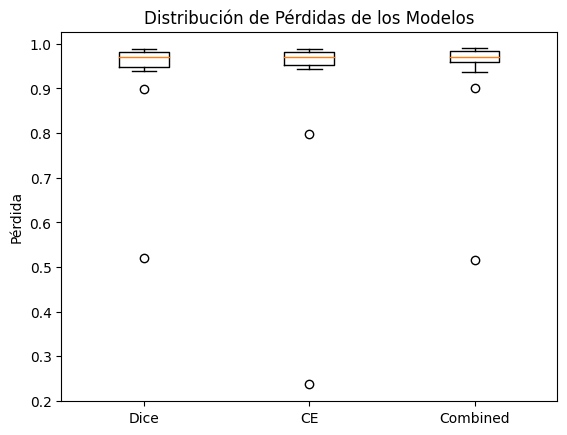

In [26]:
plt.boxplot([dices_dice,dices_CE,dices_combined], labels=["Dice", "CE", "Combined"])
plt.title("Distribución de Pérdidas de los Modelos")
plt.ylabel("Pérdida")
plt.show()